DeePyMoD ODE Example

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat
import training_adapted

import torch
# from torch.autograd import grad
# from itertools import combinations
# from functools import reduce
# from typing import Tuple
# from deepymod.utils.types import TensorList
# from deepymod.model.library import Library
import libraryODE

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(30)
torch.manual_seed(0)

# Configuring GPU or CPU
if False: #torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cpu


# Preparing a new dataset
Firstly we prepare the dataset.
Therfore we load the time series from .mat file and transform it into a Dataset object.

### Simulated with miaSim

Interaction matrix 
$A = \begin{pmatrix}
-0.5 & 30 | 25 & 0 & 0\\
-15 | -20 & -0.5 & 0 | 3 & 0 \\
0 & 0 & -0.5 & 20\\
0 & 0 & -10 & -0.5
\end{pmatrix}$

and growth rates:
$ b = (2/3, -1, 0.7, -3)$

Specify the number of species n_species and the number of timepoints n_samples in the given dataset:

In [2]:
# n_samples = None
# n_species = None

max_samples = 100
n_samples = 500
n_species = 4

# path of data file
filename = f"miaSim_GLV_{n_species}species_oscillating_zero.mat"
# filename = f"miaSim_GLV_{n_species}species_oscillating_three.mat"
# filename = f"miaSim_GLV_{n_species}species_2interactions.mat"
filepath = "C:/Users/Maria/Documents/Masterstudium/Masterarbeit/MScThesis/explore/data/01e-timeseries-miaSim/" + filename

# data should be of the form:
# [n_samples, (1 + n_species)]
# where the first colum contains the time t

# order of interactions included in the model (2 or 3)
int_order = 2

In [3]:
def create_data():
  data = loadmat(filepath)
  usol = np.real(data["ts_glv"]).astype("float32")
  usol = usol.reshape((n_samples, (1 + n_species)))
  ts = usol[0:max_samples, 0]
  data_y = usol[0:max_samples, 1:(1 + n_species)]
  T = torch.from_numpy(ts.reshape(-1, 1)).float()
  Y = torch.from_numpy(data_y).float()
  print("The coodinates have shape {}".format(T.shape))
  print("The data has shape {}".format(Y.shape))
  return T, Y

In [4]:
data = create_data()
print("Time:", data[0][0:10])
print("Data:", data[1][0:10])

The coodinates have shape torch.Size([100, 1])
The data has shape torch.Size([100, 4])
Time: tensor([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.]])
Data: tensor([[2.9663e-01, 3.2216e-01, 1.9809e-01, 4.5730e-01],
        [2.5911e-04, 3.1071e-01, 3.0372e-02, 6.9995e-02],
        [3.0258e-05, 1.0433e-01, 4.5976e-02, 7.0556e-03],
        [2.2258e-05, 3.7181e-02, 8.6877e-02, 1.2634e-03],
        [3.0534e-05, 1.3527e-02, 1.6326e-01, 7.1287e-04],
        [5.2331e-05, 4.9606e-03, 2.9037e-01, 3.0386e-03],
        [9.7244e-05, 1.8261e-03, 3.3639e-01, 1.6267e-01],
        [1.8614e-04, 6.7419e-04, 5.3882e-02, 1.3448e-01],
        [3.6020e-04, 2.4996e-04, 5.9481e-02, 1.8337e-02],
        [6.9984e-04, 9.3406e-05, 1.0509e-01, 4.4576e-03]])


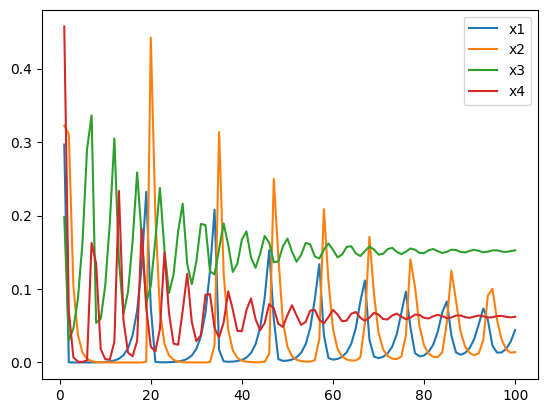

In [5]:
# plt.plot(data[0],data[1])
fig, ax = plt.subplots()
for i in np.arange(n_species):
    ax.plot(data[0], data[1][:,i], label = f"x{i+1}")
ax.legend()

Then we pass this function to the dataset class, which then adds noise to it, normalizes the coordinates and performs random subsampling to it.

In [6]:
def custom_normalize(feature):
        """minmax all features by their absolute maximum
        Args:
            feature (torch.tensor): data to be minmax normalized
        Returns:
            (torch.tensor): minmaxed data"""
        return (feature/feature.abs().max(axis=0).values)

In [7]:
# # add noise to dataset
# dataset = Dataset(
#     create_data,
#     subsampler=Subsample_random,
#     subsampler_kwargs={"number_of_samples": 500},
#     preprocess_kwargs={
#         "noise_level": 0.01,
#         "normalize_coords": False,
#         "normalize_data": False,
#     },
#     apply_normalize=custom_normalize,
#     device=device
# )

In [8]:
dataset = Dataset(
    create_data,
    device = device,
)

The coodinates have shape torch.Size([100, 1])
The data has shape torch.Size([100, 4])
Dataset is using device:  cpu


Visualization of the dataset

Text(0.5, 1.0, 'Dataset')

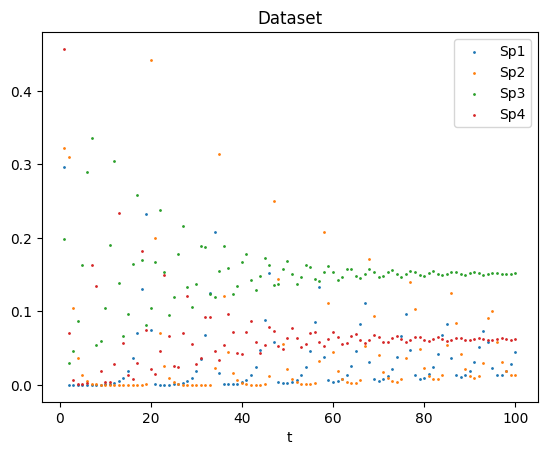

In [9]:
fig, ax = plt.subplots()
for i in np.arange(n_species):
    ax.scatter(dataset.coords.cpu(), dataset.data[:, i].cpu(), label = f"Sp{i+1}", s=1)
ax.set_xlabel("t")
ax.legend()
ax.set_title("Dataset")
# plt.xlim([0,100])

Now we need to split our data into a train and test dataloaders for PyTorch

In [10]:
train_dataloader, test_dataloader = get_train_test_loader(dataset, train_test_split=0.8)

## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [29]:
network = NN(1, [60, 60, 60, 60, 60, 60], n_species)

Configuration of the library function.

In [30]:
library = libraryODE.LibraryODE(int_order = int_order, intercept = False)

Show a list of the expressions contained in the library.

In [31]:
# get a list of coefficients contained in the library
library_values = library.get_content(dataset.data)

# number of coefficients per taxon
n_coefs = len(library_values[0])

# print the list
library_values

[['x1*1', 'x1*x1', 'x1*x2', 'x1*x3', 'x1*x4'],
 ['x2*1', 'x2*x1', 'x2*x2', 'x2*x3', 'x2*x4'],
 ['x3*1', 'x3*x1', 'x3*x2', 'x3*x3', 'x3*x4'],
 ['x4*1', 'x4*x1', 'x4*x2', 'x4*x3', 'x4*x4']]

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.

In [32]:
estimator = Threshold(0.1)
sparsity_scheduler = TrainTestPeriodic(periodicity=100, patience=200, delta=1e-5)

Configuration of the sparsity estimator

In [33]:
constraint = LeastSquares()

Now we instantiate the model and select the optimizer

In [34]:
model = DeepMoD(network, library, estimator, constraint)# .to(device)

Defining optimizer

In [35]:
optimizer = torch.optim.Adam(
    model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=5e-3
)

## Run DeepMoD

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

 19975  MSE: 4.42e-03  Reg: 1.33e-04  L1: 1.31e+01 

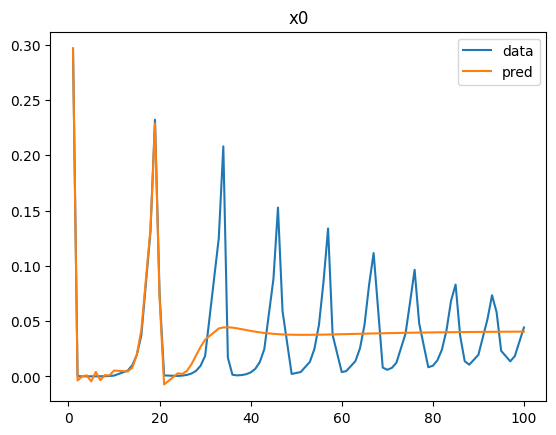

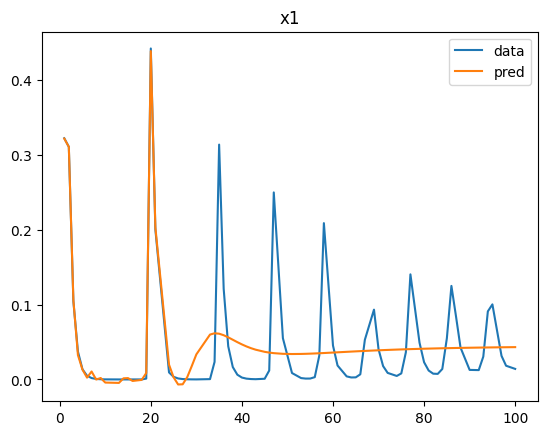

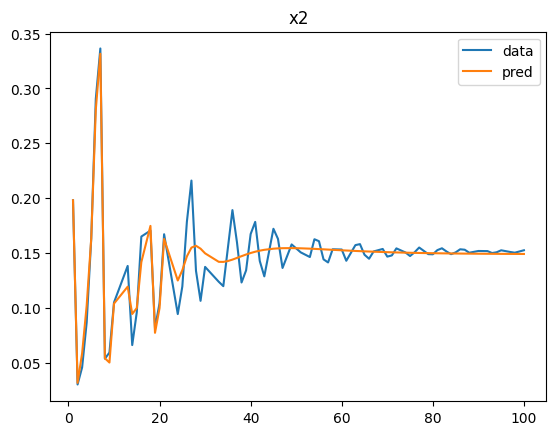

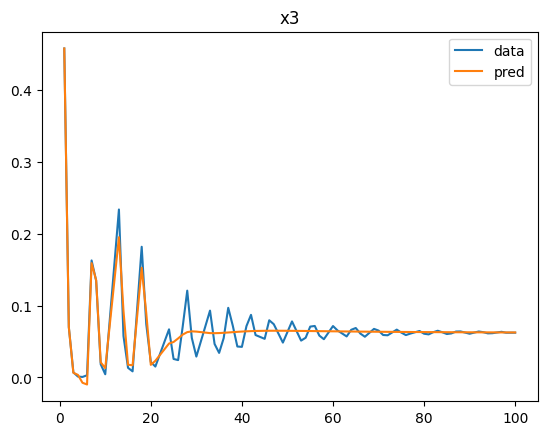

Algorithm converged. Writing model to disk.


In [36]:
training_adapted.train(
# train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    sparsity_scheduler,
    # log_dir='runs/coupled/',
    log_dir="/data/deepymod/ODE_S4/",
    max_iterations=20000,
    delta=1e-3,
    patience=100
)

Now that DeepMoD has converged, it has found the following coefficients to not be zero:

In [37]:
model.sparsity_masks

[tensor([ True, False,  True, False, False]),
 tensor([ True,  True, False, False, False]),
 tensor([ True,  True, False,  True,  True]),
 tensor([ True,  True, False,  True,  True])]

And it found the following coefficients.

In [38]:
model.estimator_coeffs()

[array([[ 0.25112042],
        [ 0.        ],
        [-1.1551156 ],
        [ 0.        ],
        [ 0.        ]], dtype=float32),
 array([[-0.34694356],
        [ 1.183668  ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]], dtype=float32),
 array([[ 0.7376887 ],
        [-0.24067688],
        [ 0.        ],
        [ 0.2908819 ],
        [-1.2458102 ]], dtype=float32),
 array([[-3.1057906 ],
        [-0.46521607],
        [ 0.        ],
        [ 3.7930636 ],
        [-0.20128503]], dtype=float32)]

## Analysis/Visualization of the train() loss

In [39]:
import os
from tensorflow.python.summary.summary_iterator import summary_iterator

In [40]:
# # get list of all output values that were calculated during train()
# os.listdir("/data/deepymod/ODE_S4/")

In [41]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_mse_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_mse_output_0/" + tmp_file

train_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        train_loss = np.append(train_loss, mse)
        i += 1

# train_loss

In [42]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/remaining_MSE_test_val_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/remaining_MSE_test_val_0/" + tmp_file

test_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        test_loss = np.append(test_loss, mse)
        i += 1

# test_loss

In [43]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_l1_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_l1_output_0/" + tmp_file

l1_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        l1_loss = np.append(l1_loss, mse)
        i += 1

# l1_loss

In [44]:
tmp_file = os.listdir("/data/deepymod/ODE_S4/loss_reg_output_0/")[-1]
file_dir = "/data/deepymod/ODE_S4/loss_reg_output_0/" + tmp_file

reg_loss = np.array([])
i = 0

for summary in summary_iterator(file_dir):
    for value in summary.summary.value:
        # Extract relevant information from the event
        mse = value.simple_value
        reg_loss = np.append(reg_loss, mse)
        i += 1

# reg_loss

(0.0, 50.0)

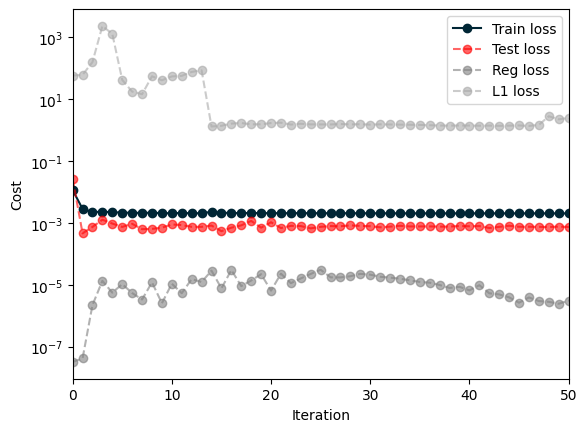

In [45]:
fig, ax = plt.subplots()
ax.plot(train_loss, c='#002635', marker='o', label='Train loss')
ax.plot(test_loss, c='red', marker='o', ls='--', alpha=0.6, label='Test loss')
ax.plot(reg_loss, c='gray', marker='o', ls='--', alpha=0.6, label='Reg loss')
ax.plot(l1_loss, c='darkgray', marker='o', ls='--', alpha=0.6, label='L1 loss')
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost')
ax.legend()
plt.xlim([0, 50])

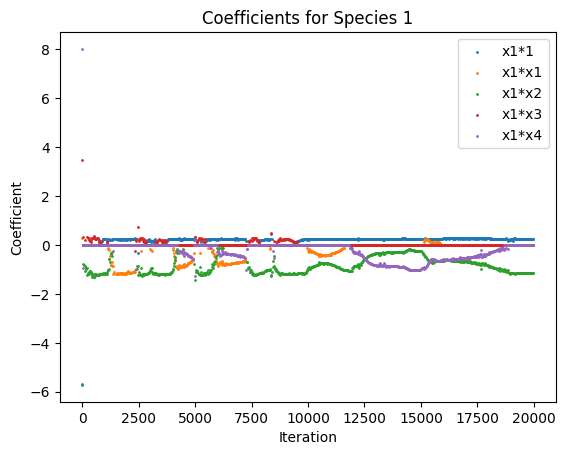

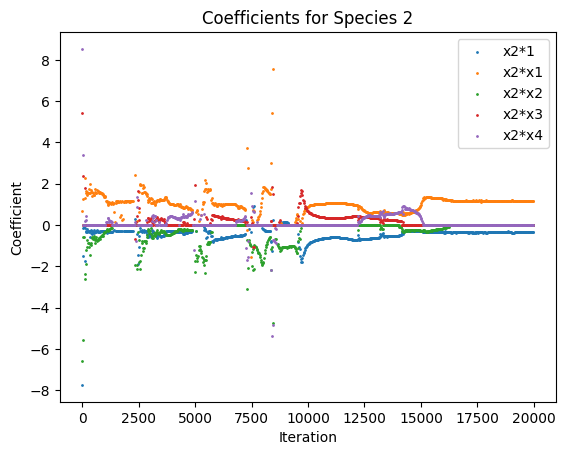

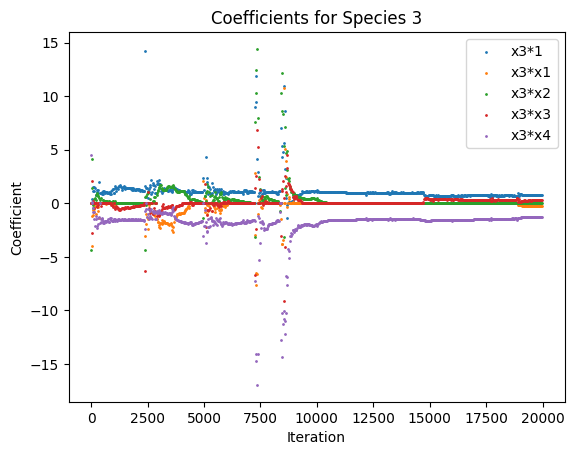

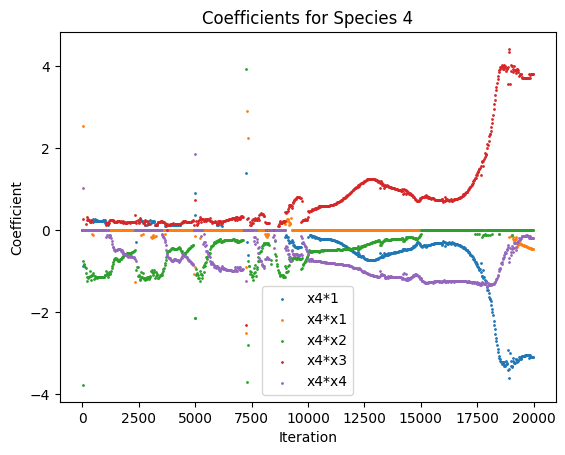

In [46]:
for taxon in np.arange(n_species):
    output = []

    for coef in np.arange(n_coefs):
        folder_dir = f"/data/deepymod/ODE_S4/estimator_coeffs_output_{taxon}_coeff_{coef}/"
        tmp_file = os.listdir(folder_dir)[-1]
        file_dir = folder_dir + tmp_file

        output_coef = np.array([])
        i = 0
        # os.listdir(file_dir)
        for summary in summary_iterator(file_dir):
            for value in summary.summary.value:
                # Extract relevant information from the event
                coef_val = value.simple_value
                output_coef = np.append(output_coef, coef_val)
                i += 1
        output.append(output_coef)

    n_iteration = len(output[0])

    fig, ax = plt.subplots()
    for coef in np.arange(n_coefs):
        # ax.plot(output[coef], marker='o', ls='--', alpha=0.6, label=f'Coef {coef}')
        ax.scatter(np.arange(25*n_iteration, step = 25), output[coef], label = f'{library_values[taxon][coef]}', s=1)
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Coefficient')
    ax.set_title(f'Coefficients for Species {taxon+1}')
    ax.legend()
    # plt.xlim([0, 1000])
    # plt.ylim([-50, 50])